 ______  ___     ______                        _________
___   |/  /________  /_______ _______ ______________  /
__  /|_/ /_  __ \_  __ \  __ `/_  __ `__ \  _ \  __  / 
_  /  / / / /_/ /  / / / /_/ /_  / / / / /  __/ /_/ /  
/_/  /_/  \____//_/ /_/\__,_/ /_/ /_/ /_/\___/\__,_/   
                                                       
_____________ _________      ___________        _________            
___    |__  /_______  /_____ ___  /__  /_______ ______  /____________
__  /| |_  __ \  __  /_  __ `/_  /__  //_/  __ `/  __  /_  _ \_  ___/
_  ___ |  /_/ / /_/ / / /_/ /_  / _  ,<  / /_/ // /_/ / /  __/  /    
/_/  |_/_.___/\__,_/  \__,_/ /_/  /_/|_| \__,_/ \__,_/  \___//_/     
                                                                     



## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

2024-08-19 08:47:19.629313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 08:47:19.629435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 08:47:19.778328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Initialize Parameters

In [2]:
img_height, img_width = 224, 224
batch_size = 32
num_classes = 10

training_set   = r"/kaggle/input/fastfood-10classes-224x224pixels/Train"
validation_set = r"/kaggle/input/fastfood-10classes-224x224pixels/Valid"
test_set       = r"/kaggle/input/fastfood-10classes-224x224pixels/Test"

## Data Augmentation and Generator Setup

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    training_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    validation_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255,
    fill_mode='nearest'
)
testing_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 13499 images belonging to 10 classes.
Found 350 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


## Visualization

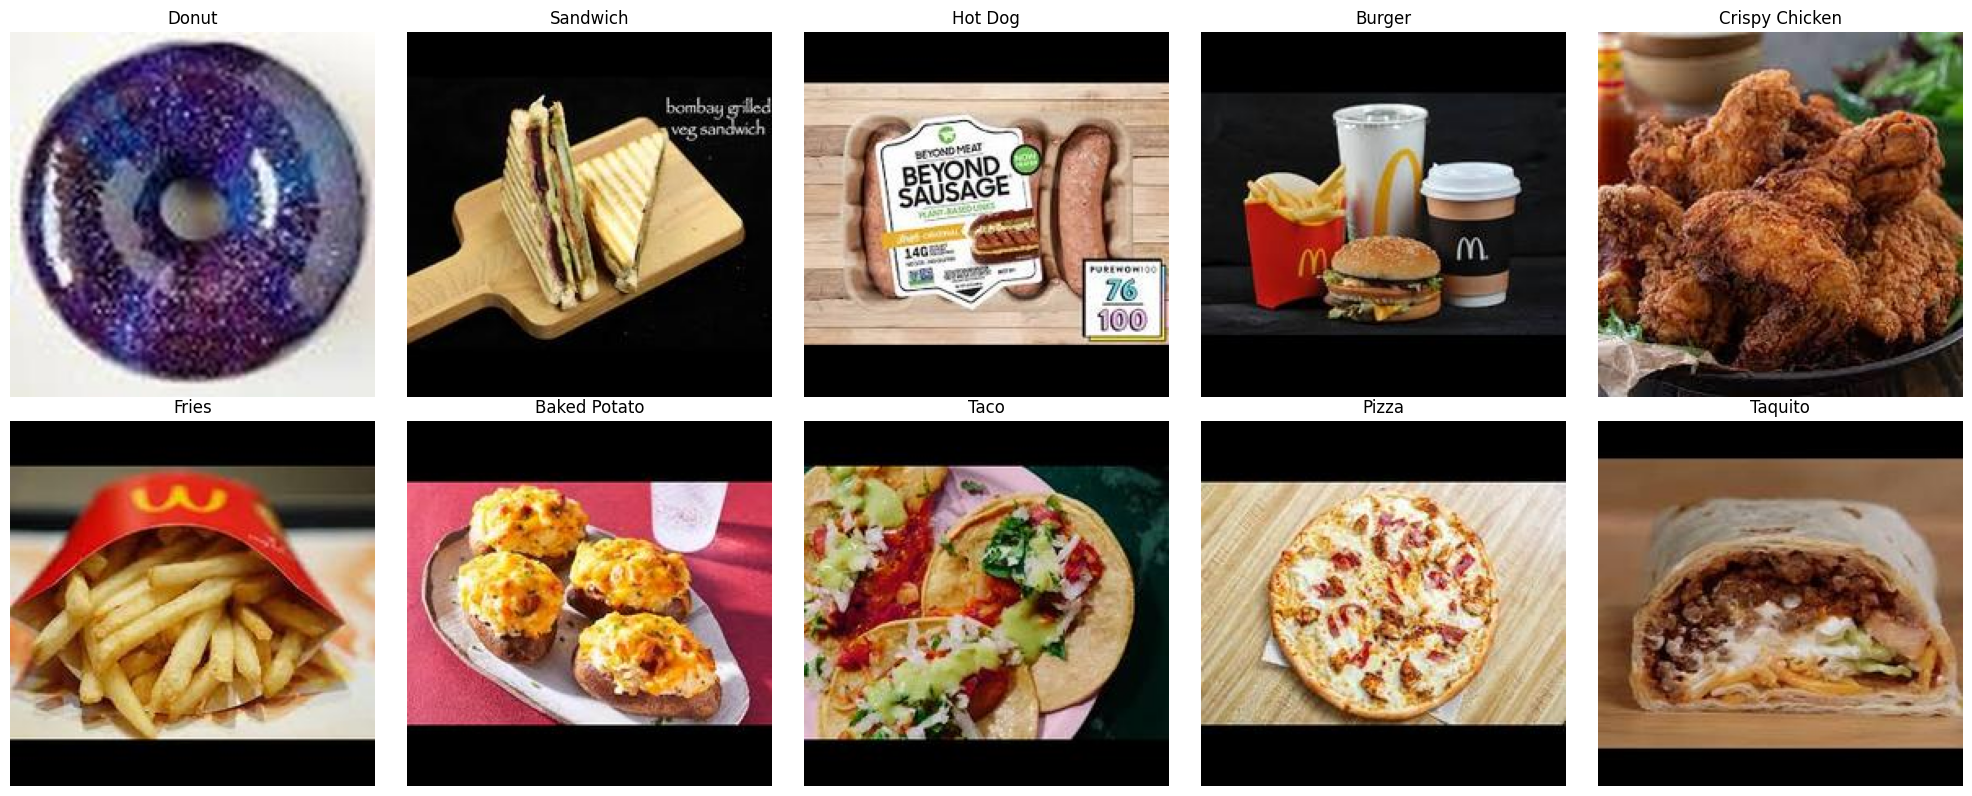

In [4]:
def plot_sample():
    subfolders = [f.path for f in os.scandir(test_set) if f.is_dir()]
    num_subplots = len(subfolders)

    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()

    for i, subfolder in enumerate(subfolders):
        images = [f for f in os.listdir(subfolder)]
        selected_image = random.choice(images)
        img_path = os.path.join(subfolder, selected_image)
        img = mpimg.imread(img_path)

        axs[i].imshow(img)
        axs[i].set_title(os.path.basename(subfolder))
        axs[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

plot_sample()

## Modeling

In [5]:
def plot_random_predictions(y_true, y_pred, y_pred_classes, generator=testing_generator, n=10):
    classes_map = generator.class_indices
    class_names = list(classes_map.keys())

    indices = np.random.choice(len(y_true), size=n, replace=False)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
    fig.suptitle(f'Sample of {n} Random Predictions', fontsize=16)

    for i, idx in enumerate(indices):
        image_path = generator.filepaths[idx]
        image = load_img(image_path, target_size=(224, 224))
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Real: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}')

    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    # Get the accuracy and validation accuracy from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Get the number of epochs
    epochs = range(len(acc))
    
    # Plot the training and validation accuracy
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def print_random_predictions(y_true, y_pred_classes, n=10):    
    indices = np.random.choice(len(y_true), size=n, replace=False)
    print(f"\nSample of {n} random real classes matched with the predicted classes:")
    for idx in indices:
        print(f"Real class: {y_true[idx]}, Predicted class: {y_pred_classes[idx]}")
        
def evaluation():
    test_loss, test_accuracy = model.evaluate(testing_generator)
    print(f"Test Loss     : {round(test_loss, 4)}")
    print(f"Test Accuracy : {round(test_accuracy, 4)}")

    y_pred = model.predict(testing_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = testing_generator.classes

    accuracy  = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall    = recall_score(y_true, y_pred_classes, average='weighted')
    f1        = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"Accuracy  : {round(accuracy, 4)}")
    print(f"Precision : {round(precision, 4)}")
    print(f"Recall    : {round(recall, 4)}")
    print(f"F1 Score  : {round(f1, 4)}")


### 1. Simple Model Architecture

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,042 (45.64 MB)

 Trainable params: 11,964,042 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [10]:
# Train the model
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - accuracy: 0.1162 - loss: 2.3148 - val_accuracy: 0.1688 - val_loss: 2.2445 - learning_rate: 0.0010
Epoch 2/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1250 - loss: 2.2562 - val_accuracy: 0.2667 - val_loss: 2.3930 - learning_rate: 0.0010
Epoch 3/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.1564 - loss: 2.2520 - val_accuracy: 0.2313 - val_loss: 2.1001 - learning_rate: 0.0010
Epoch 4/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2500 - loss: 2.1715 - val_accuracy: 0.2333 - val_loss: 2.0870 - learning_rate: 0.0010
Epoch 5/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.1989 - loss: 2.1540 - val_accuracy: 0.2719 - val_loss: 1.9864 - learning_rate: 0.0010
Epoch 6/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.2500 - loss: 2.0732 - val_accuracy: 0.3000 - val_loss: 1.9874 - learning_rate: 0.0010
Epoch 7/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.2747 - loss: 2.0

### Evaluation

In [11]:
evaluation()

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.5813 - loss: 1.3176
Test Loss     : 1.4497
Test Accuracy : 0.5187
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step
Accuracy  : 0.5187
Precision : 0.5647
Recall    : 0.5187
F1 Score  : 0.5223


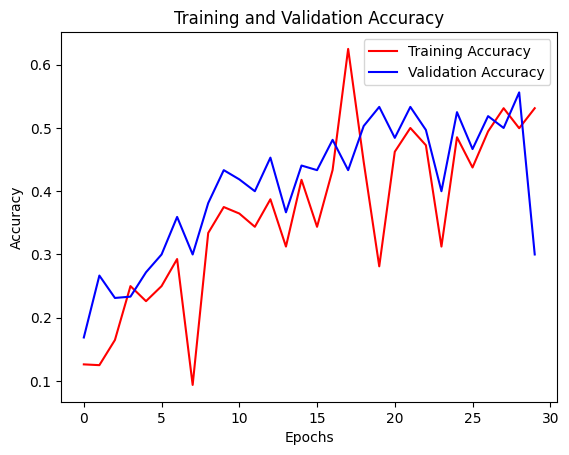

In [12]:
plot_accuracy(history)

In [13]:
y_true = testing_generator.classes
y_pred = model.predict(testing_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print_random_predictions(y_true, y_pred_classes, 20)

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step

Sample of 20 random real classes matched with the predicted classes:
Real class: 3, Predicted class: 3
Real class: 4, Predicted class: 4
Real class: 3, Predicted class: 3
Real class: 3, Predicted class: 9
Real class: 1, Predicted class: 5
Real class: 6, Predicted class: 8
Real class: 7, Predicted class: 6
Real class: 6, Predicted class: 8
Real class: 2, Predicted class: 2
Real class: 5, Predicted class: 5
Real class: 4, Predicted class: 9
Real class: 2, Predicted class: 2
Real class: 1, Predicted class: 1
Real class: 7, Predicted class: 7
Real class: 0, Predicted class: 8
Real class: 2, Predicted class: 2
Real class: 3, Predicted class: 3
Real class: 8, Predicted class: 9
Real class: 7, Predicted class: 6
Real class: 2, Predicted class: 4


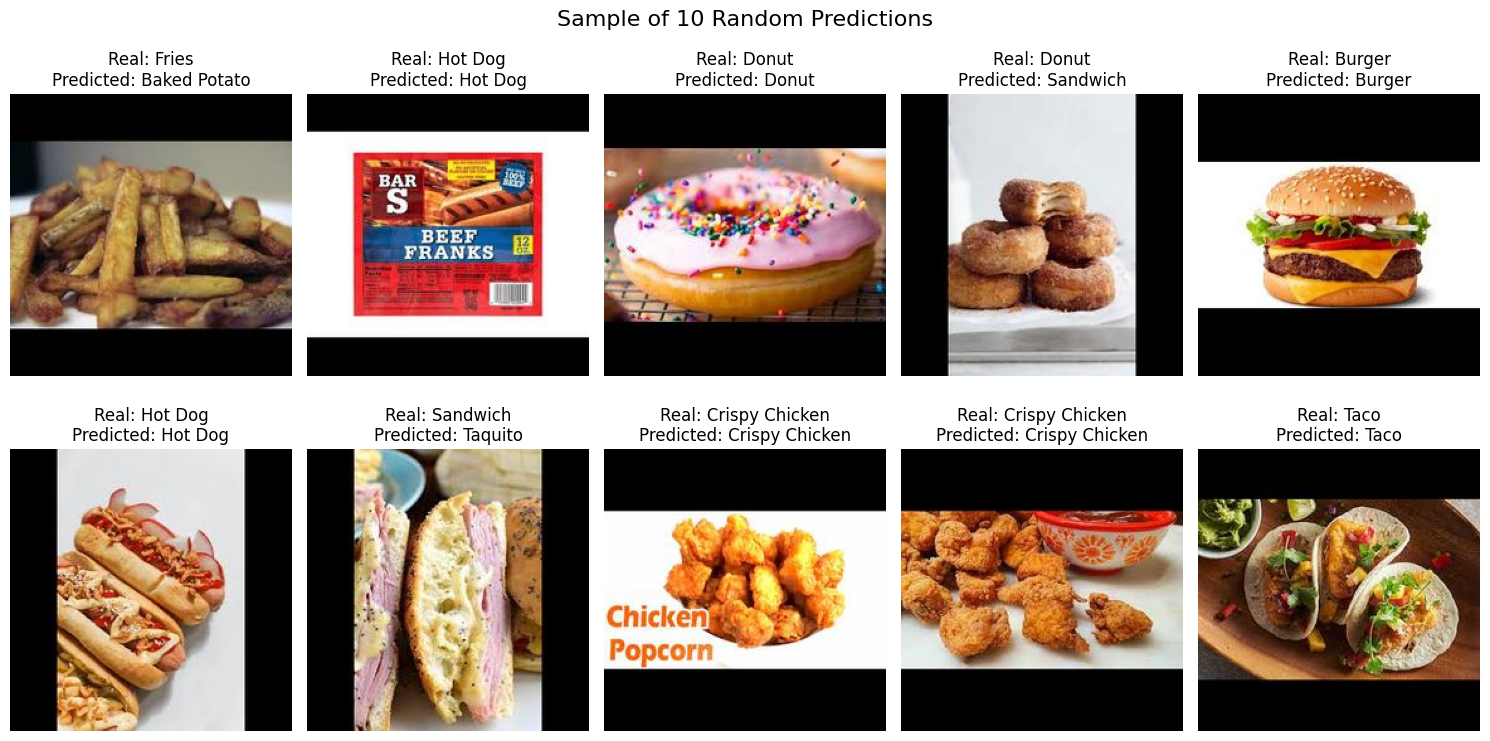

In [14]:
plot_random_predictions(y_true, y_pred, y_pred_classes)

In [15]:
model.save(r"/kaggle/working/Model1_FastFood_10Classes_224x224pixels_30epoch V1.h5")

### 2. Pre-Trained Model (EfficientNetB0)

In [16]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,371,565 (20.49 MB)

 Trainable params: 5,329,542 (20.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [17]:
# Train the model
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2347s 5s/step - accuracy: 0.6555 - loss: 1.0682 - val_accuracy: 0.1375 - val_loss: 2.9100 - learning_rate: 0.0010
Epoch 2/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7188 - loss: 0.7740 - val_accuracy: 0.1333 - val_loss: 2.9480 - learning_rate: 0.0010
Epoch 3/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2264s 5s/step - accuracy: 0.8157 - loss: 0.6122 - val_accuracy: 0.7500 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 4/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7812 - loss: 0.6819 - val_accuracy: 0.7333 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 5/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2237s 5s/step - accuracy: 0.8457 - loss: 0.5089 - val_accuracy: 0.7969 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 6/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9062 - loss: 0.5442 - val_accuracy: 0.8333 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 7/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 2261s 5s/step - accuracy: 0.8597 - loss: 0

In [18]:
model.save(r"/kaggle/working/EfficientNetB01_FastFood_10Classes_224x224pixels_30EpochsTrainingV1.h5")

In [20]:
evaluation()

47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9162 - loss: 0.3886
Test Loss     : 0.5485
Test Accuracy : 0.8773
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
Accuracy  : 0.8773
Precision : 0.8994
Recall    : 0.8773
F1 Score  : 0.8773


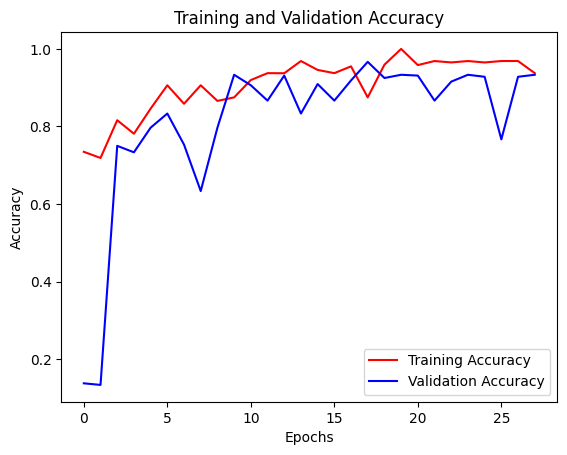

In [21]:
plot_accuracy(history)

In [22]:
y_true = testing_generator.classes
y_pred = model.predict(testing_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print_random_predictions(y_true, y_pred_classes, 20)

47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step

Sample of 20 random real classes matched with the predicted classes:
Real class: 2, Predicted class: 2
Real class: 3, Predicted class: 3
Real class: 9, Predicted class: 9
Real class: 5, Predicted class: 5
Real class: 0, Predicted class: 0
Real class: 8, Predicted class: 8
Real class: 6, Predicted class: 2
Real class: 7, Predicted class: 7
Real class: 6, Predicted class: 6
Real class: 6, Predicted class: 0
Real class: 7, Predicted class: 7
Real class: 9, Predicted class: 9
Real class: 5, Predicted class: 5
Real class: 3, Predicted class: 3
Real class: 3, Predicted class: 3
Real class: 7, Predicted class: 7
Real class: 5, Predicted class: 5
Real class: 5, Predicted class: 5
Real class: 1, Predicted class: 1
Real class: 8, Predicted class: 8


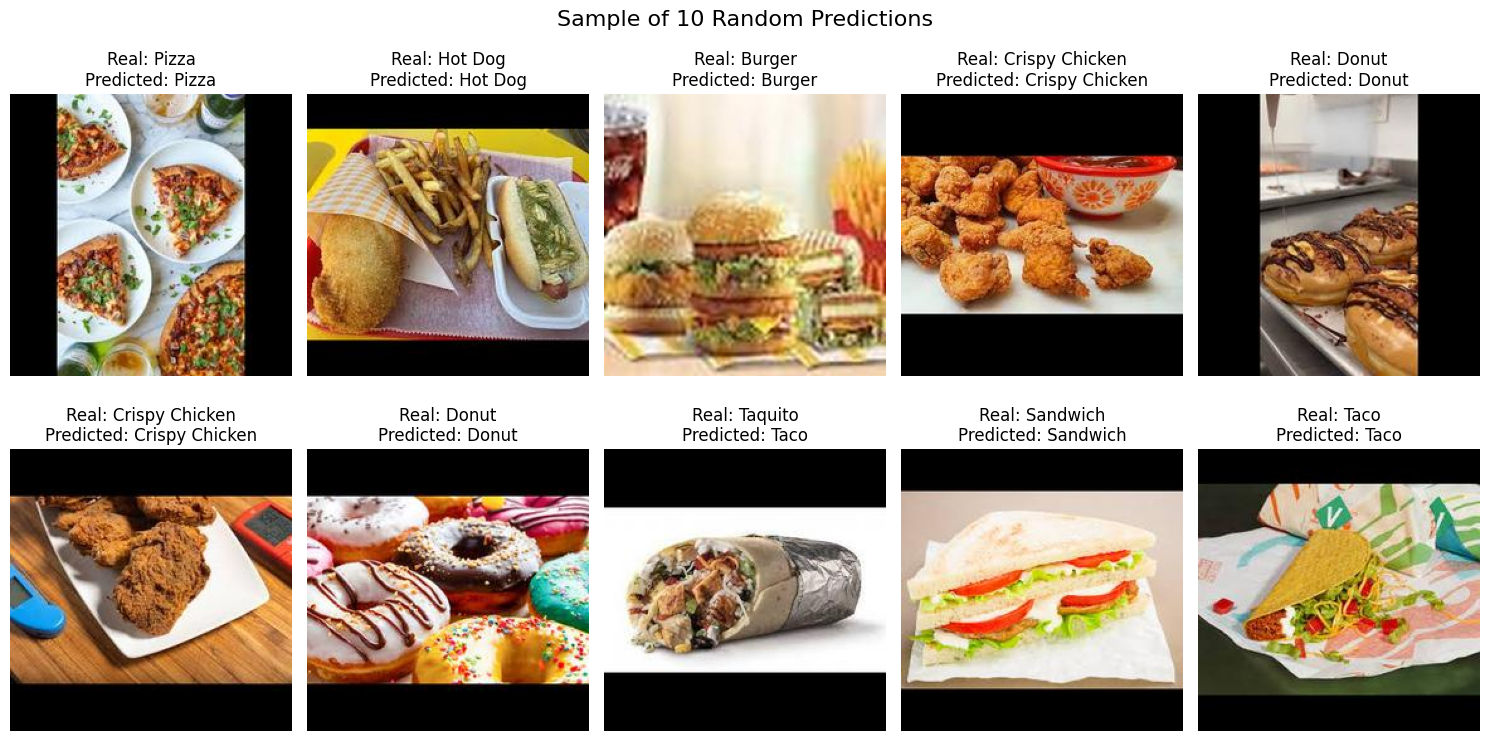

In [23]:
plot_random_predictions(y_true, y_pred, y_pred_classes)

#### Fine Tuning

In [6]:
model = tf.keras.models.load_model("/kaggle/input/efficientnetb01_fastfood_10classes/tensorflow2/default/1/EfficientNetB01_FastFood_10Classes_224x224pixels_30EpochsTrainingV1.h5")

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [7]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

history_fine = model.fit(
    train_generator,
    epochs=50,
    initial_epoch=30,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 31/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 642s 1s/step - accuracy: 0.9466 - loss: 0.1753 - val_accuracy: 0.8906 - val_loss: 0.4541 - learning_rate: 0.0010
Epoch 32/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9375 - loss: 0.1306 - val_accuracy: 0.9333 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 33/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.9460 - loss: 0.1697 - val_accuracy: 0.8813 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 34/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8438 - loss: 0.4623 - val_accuracy: 0.9000 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 35/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.9511 - loss: 0.1625 - val_accuracy: 0.8969 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 36/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - loss: 0.0988 - val_accuracy: 0.8667 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 37/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.9499 - loss

In [8]:
evaluation()

47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9176 - loss: 0.4379
Test Loss     : 0.6027
Test Accuracy : 0.8827
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
Accuracy  : 0.8827
Precision : 0.9009
Recall    : 0.8827
F1 Score  : 0.8829


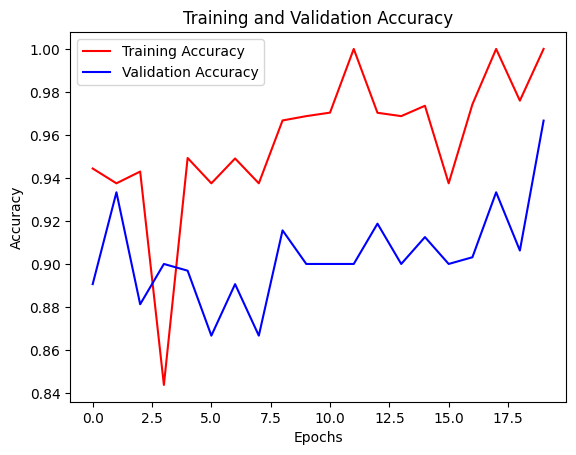

In [9]:
plot_accuracy(history_fine)

In [10]:
y_true = testing_generator.classes
y_pred = model.predict(testing_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print_random_predictions(y_true, y_pred_classes, 20)

47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step

Sample of 20 random real classes matched with the predicted classes:
Real class: 7, Predicted class: 7
Real class: 3, Predicted class: 3
Real class: 1, Predicted class: 1
Real class: 3, Predicted class: 3
Real class: 2, Predicted class: 2
Real class: 5, Predicted class: 8
Real class: 4, Predicted class: 0
Real class: 8, Predicted class: 8
Real class: 7, Predicted class: 1
Real class: 1, Predicted class: 1
Real class: 5, Predicted class: 5
Real class: 6, Predicted class: 7
Real class: 5, Predicted class: 5
Real class: 3, Predicted class: 3
Real class: 3, Predicted class: 3
Real class: 3, Predicted class: 3
Real class: 1, Predicted class: 1
Real class: 1, Predicted class: 8
Real class: 1, Predicted class: 1
Real class: 2, Predicted class: 2


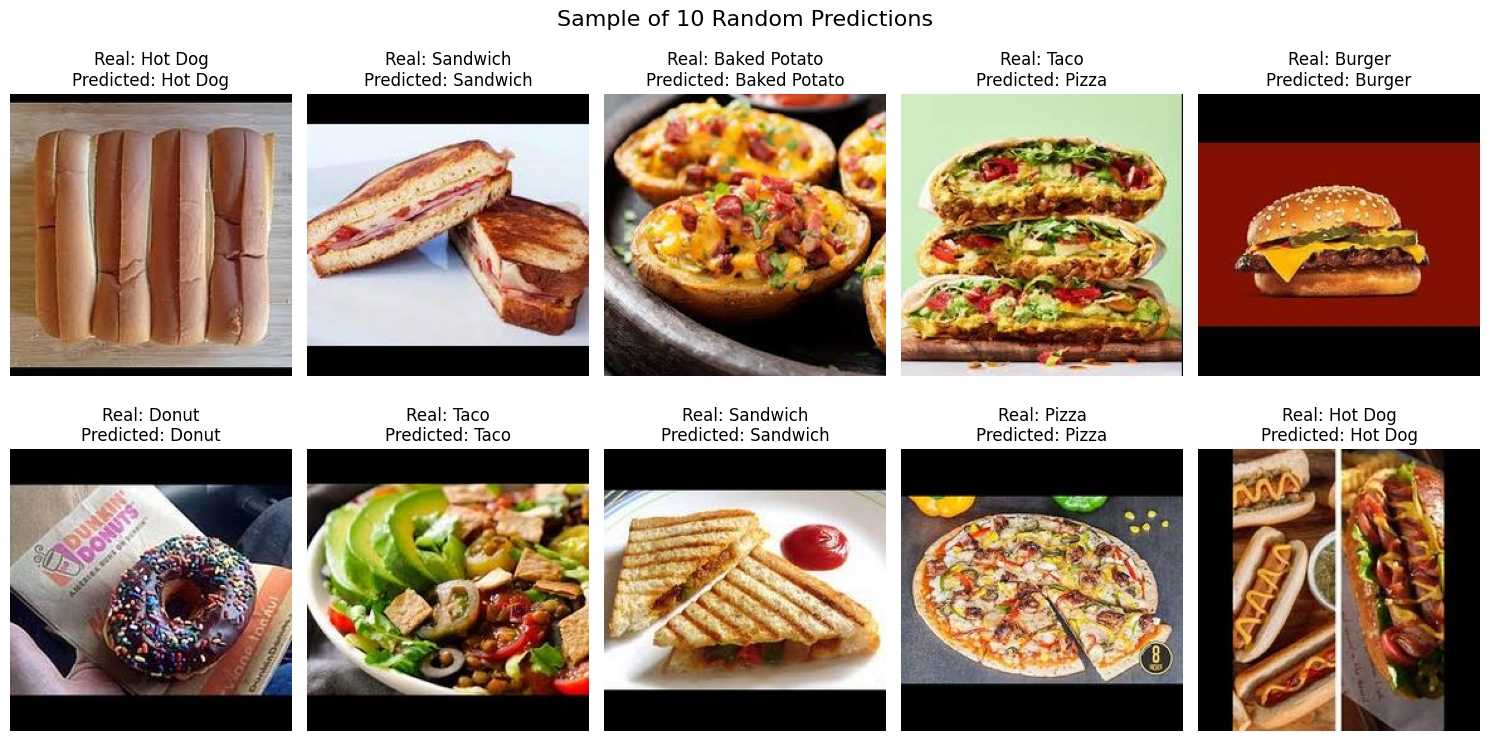

In [11]:
plot_random_predictions(y_true, y_pred, y_pred_classes)